In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax, vmap
from sgmcmcjax.kernels import build_sgld_kernel, build_sgldCV_kernel, build_badodab_kernel, build_baoab_kernel, build_sghmc_kernel

import context
from models.logistic_regression.logistic_regression_model import gen_data, loglikelihood, logprior
from samplers.timed_sampler import timed_sampler
from tuning.gridsearch import run_gridsearch

# Logistic regression

In [2]:


key = random.PRNGKey(42)
dim = 10
Ndata = 100000

theta_true, X, y_data = gen_data(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)


batch_size = int(0.01*X_train.shape[0])
data = (X_train, y_train)


generating data, with N=100000 and dim=10
(80000, 10) (20000, 10)


## timed sampler

In [3]:
@jit
def logloss_samples(samples):
    samples = jnp.array(samples)
    _batch_loglik = jit(vmap(loglikelihood, in_axes=(None, 0, 0)))

    @jit
    def _logloss(theta, X_test=X_test, y_test=y_test):
        return -jnp.mean(_batch_loglik(theta, X_test, y_test))

    batch_logloss = jit(vmap(_logloss, in_axes=(0, None, None)))
    return jnp.mean(batch_logloss(samples, X_test, y_test))


Running gridsearch for dt
Number of grid points: 6
{'dt': 0.1}



{'dt': 0.01}



{'dt': 0.001}



{'dt': 1e-04}



{'dt': 1e-05}



{'dt': 1e-06}



[Buffer(69.25246, dtype=float32), Buffer(5.6542134, dtype=float32), Buffer(0.5489699, dtype=float32), Buffer(0.14526431, dtype=float32), Buffer(0.14512184, dtype=float32), Buffer(0.14509353, dtype=float32)]


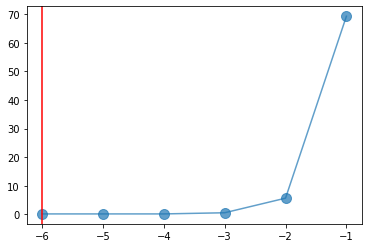

In [5]:
mykernel = lambda dt: build_sgld_kernel(dt, loglikelihood, logprior,
                                          data, int(0.1*X_train.shape[0]))

Niters = 1000
list_hyperparams, ll_list = run_gridsearch(key, mykernel, logloss_samples, Niters, theta_true)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.argmin(ll_list)], c='r')

print(ll_list)

Running gridsearch for dt
Number of grid points: 6
{'dt': 0.1}



{'dt': 0.01}



{'dt': 0.001}



{'dt': 1e-04}



{'dt': 1e-05}



{'dt': 1e-06}



[Buffer(68.94568, dtype=float32), Buffer(5.619133, dtype=float32), Buffer(0.54800004, dtype=float32), Buffer(0.14513311, dtype=float32), Buffer(0.14510931, dtype=float32), Buffer(0.14509103, dtype=float32)]


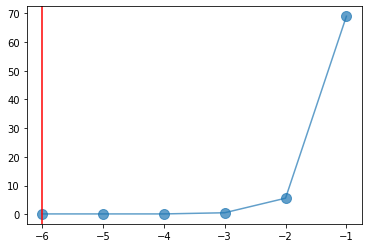

In [8]:
mykernel = lambda dt: build_sgldCV_kernel(dt, loglikelihood, logprior,
                                          data, int(0.1*X_train.shape[0]), theta_true)

Niters = 1000
list_hyperparams, ll_list = run_gridsearch(key, mykernel, logloss_samples, Niters, theta_true)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.argmin(ll_list)], c='r')

print(ll_list)

In [13]:
grid_params = {'log_dt': -jnp.arange(1., 7.), "L": jnp.arange(5,15,5)}
mykernel = lambda dt, L: build_sghmc_kernel(dt, L, loglikelihood, logprior,
                                          data, int(0.1*X_train.shape[0]))

Niters = 1000
list_hyperparams, ll_list = run_gridsearch(key, mykernel, logloss_samples, Niters, theta_true, grid_params)

print(f"\nOptimal hyperparameter: {list_hyperparams[np.argmin(ll_list)]}")

Running gridsearch for L, dt
Number of grid points: 18
{'L': 5, 'dt': 0.1}



{'L': 5, 'dt': 0.01}



{'L': 5, 'dt': 0.001}



{'L': 5, 'dt': 1e-04}



{'L': 5, 'dt': 1e-05}



{'L': 5, 'dt': 1e-06}



{'L': 10, 'dt': 0.1}



{'L': 10, 'dt': 0.01}



{'L': 10, 'dt': 0.001}



{'L': 10, 'dt': 1e-04}



{'L': 10, 'dt': 1e-05}



{'L': 10, 'dt': 1e-06}



{'L': 15, 'dt': 0.1}



{'L': 15, 'dt': 0.01}



{'L': 15, 'dt': 0.001}



{'L': 15, 'dt': 1e-04}



{'L': 15, 'dt': 1e-05}



{'L': 15, 'dt': 1e-06}




Optimal hyperparameter: {'L': 5, 'dt': 1e-06}


Running gridsearch for dt
Number of grid points: 6
{'dt': 0.1}



{'dt': 0.01}



{'dt': 0.001}



{'dt': 1e-04}



{'dt': 1e-05}



{'dt': 1e-06}



[Buffer(2.7712564, dtype=float32), Buffer(0.14606486, dtype=float32), Buffer(0.14578487, dtype=float32), Buffer(0.14514202, dtype=float32), Buffer(0.14502358, dtype=float32), Buffer(0.14502405, dtype=float32)]


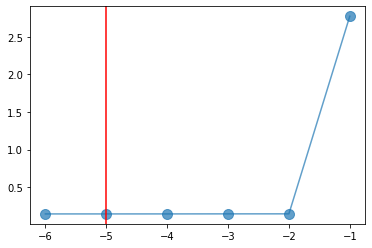

In [14]:
mykernel = lambda dt: build_badodab_kernel(dt, loglikelihood, logprior,
                                          data, int(0.1*X_train.shape[0]))

Niters = 1000
list_hyperparams, ll_list = run_gridsearch(key, mykernel, logloss_samples, Niters, theta_true)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.argmin(ll_list)], c='r')

print(ll_list)

Running gridsearch for 6 grid values
{'dt': 0.1}



{'dt': 0.01}



{'dt': 0.001}



{'dt': 1e-04}



{'dt': 1e-05}



{'dt': 1e-06}


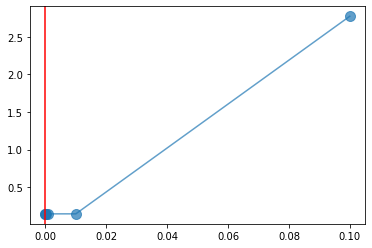

In [8]:
mykernel = lambda dt: build_badodab_kernel(dt, loglikelihood, logprior,
                                          data, int(0.1*X_train.shape[0]))

Niters = 1000
list_hyperparams, ll_list = run_gridsearch(key, mykernel, logloss_samples, Niters, theta_true)


log_dt_grid = [elem['dt'] for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.argmin(ll_list)], c='r')